In [69]:
import pandas as pd
import numpy as np
import os, sys
import random
import math
import matplotlib.pyplot as plt
from scipy import stats
import itertools
import json
from scipy.optimize import minimize
from PIL import Image

In [30]:
testing = False
rseed = 0

# read in the working directories and iteration number
if len(sys.argv) == 4:
    # set locations for working files
    automation_dir = sys.argv[1]
    attpcroot_dir = sys.argv[2]
    iteration = int(sys.argv[3])
    
    if rseed == 0:
        rseed = random.randint(1,1000000)
    
else:
    if testing:
        print("TESTING MODE")
        automation_dir = '/mnt/analysis/e17023/Adam/GADGET2/'
        attpcroot_dir = '/mnt/analysis/e17023/Adam/ATTPCROOTv2/'
        iteration = 2
        print(f"Using default directories and iteration {iteration}")
    else:
        print("Usage: python tuning.py <automation_dir> <attpcroot_dir> <iteration>")
        raise ValueError("Incorrect number of arguments passed to tuning.py")
rseed += iteration # to ensure that the random seed is different for each iteration

Usage: python tuning.py <automation_dir> <attpcroot_dir> <iteration>


ValueError: Incorrect number of arguments passed to tuning.py

In [ ]:
def indicator_file(file_type, indicator_directory=automation_dir):
    df = pd.DataFrame([0])
    df.to_csv(indicator_directory + file_type + '.csv', index=False)
    print(file_type + ' FILE CREATED')

In [70]:
def initialize_files():
    param_df = pd.DataFrame(columns=['Sim', 'Status', 'P0', 'E0', 'P1', 'E1', 'N', 'Seed', 'Score'])
    tuning_log = {
        'Parameters': { # initial values of tuning parameters, changed to best fit values after each iteration
            'Threshold' : 100
        },
        'Gradient' : {}, # measured gradient of each parameter after each iteration, used to calculate new parameter values
        'N': 100, # number of events per simulation
        'Seed' : 2, # seed to use for all simulations (eliminates random variation for simpler tuning, effect can be minimized with large N)
        'TuningParticles' : ['1682p'], # Particle types to use for tuning
        'LearningRate' : 0.1, 
        'TestJump' : 0.1, # Learning Rate * TestJump * Old Gradient = amount to change each parameter by for measuring the gradient
        'IntParams' : ['Threshold', 'Gain', 'GETGain', 'PeakingTime'], # parameters that must be integers
        'ZeroEnergy' : 0.001, # energy of particles that are considered to have zero energy (bad fix of a bug)
        'Batch' : 0, # batch number
        
    }
    
     # initialize gradient to +10% of initial parameter values
    tuning_log['Gradient'] = {param: tuning_log['Parameters'][param] * 0.1 for param in tuning_log['Parameters'].keys()}
    
    # batch specific parameters
    tuning_log['VarParam'] = list(tuning_log['Parameters'].keys())[0] # currently varying parameter
    tuning_log['VarPType'] = tuning_log['TuningParticles'][0] # currently varying particle type
    
    # save tuning information to json file for future iterations
    with open(automation_dir + 'simInput/tuning_log.json', 'w') as f:
        json.dump(tuning_log, f, indent=4)
    
    # add blank columns for each parameter and save to csv
    for param in tuning_log['Parameters'].keys():
        param_df[param] = np.nan
    param_df.to_csv(automation_dir + 'simInput/parameters.csv', index=False)
    
    print('Tuning Files Initialized')

In [ ]:
if iteration == 0:
    initialize_files()
else:
    tuning_log = json.load(open(automation_dir + 'simInput/tuning_log.json'))
    param_df = pd.read_csv(automation_dir + 'simInput/parameters.csv')

In [ ]:
# Read in the parameter file and validate that all simulations have been run successfully
param_df = pd.read_csv(automation_dir + 'simInput/parameters.csv')

if 0 in param_df['Status'].values:
    # There are still simulations queued, so exit without doing anything
    sys.exit(0)
elif 1 in param_df['Status'].values:
    print("Error in h5 creation of one of the simulations, exiting")
    indicator_file('STOP')
    sys.exit(1)
elif 2 in param_df['Status'].values:
    print("Error in image creation of one of the simulations, exiting")
    indicator_file('STOP')
    sys.exit(1)
elif 3 in param_df['Status'].values:
    print("Error in GIF creation of one of the simulations, exiting")
    indicator_file('STOP')
    sys.exit(1)

# 4 indicates that the simulation has been run successfully
# 5 indicates that the simulation has been run successfully and has been used for tuning already

In [71]:
# IMAGE PROCESSING FUNCTIONS
def get_energy(image, scale=3000):
    # extract energy bar from image
    ebar_bounds = ((5,8),(145,17))
    ebar = image[ebar_bounds[0][0]:ebar_bounds[1][0], ebar_bounds[0][1]:ebar_bounds[1][1], :]

    ebar_slice = np.array([np.mean(ebar[i,1,:]) for i in range(ebar.shape[0])]) # 1d slice of energy bar
    for i in range(ebar_slice.shape[0]):
        if ebar_slice[i] != 255:
            break
    proportion_filled = 1 - (i-1)/ebar_slice.shape[0] # proportion of energy bar filled (0-1)
    event_energy = (proportion_filled * scale) # scale to max energy
    event_energy += 27.766 # offset to match data
    return event_energy
def get_track(image):
    # extract padplane from image
    padplane_bounds = ((3,40),(148,185))
    padplane = image[padplane_bounds[0][0]:padplane_bounds[1][0], padplane_bounds[0][1]:padplane_bounds[1][1], :]
    
    # extract track from padplane
    track = padplane[:,:,0].copy() # copy red channel for track
    track[track == 255] = 0 # set white to black
    track_bounds = np.where(track != 0) # get track bounds
    track_bounds = ((min(track_bounds[0]), max(track_bounds[0])+1), (min(track_bounds[1]), max(track_bounds[1])+1))
    track = track[track_bounds[0][0]:track_bounds[0][1], track_bounds[1][0]:track_bounds[1][1]] # crop track
    track = track[::4,::4] # downsample track to remove grid effect
    return track
def get_trace(image):
    trace_img = image[150:,:,0] # extract trace from image
    trace_cumsum = np.cumsum(255-trace_img, axis=0) # cumulative sum of trace
    trace = trace_cumsum[-1,:].astype(float) # height of trace at each pixel
    
    trace_diff = np.abs(np.diff(trace))
    edges = np.arange(trace_diff.shape[0])[trace_diff > 100] # find edges of trace
    
    # crop trace_height to edges
    trace = trace[edges[0]+5:edges[-1]-5]
    
    # set baseline to average of first and last 10 pixels
    baseline = np.mean(np.concatenate((trace[:10], trace[-10:])))
    trace -= baseline # subtract baseline
    trace[trace < 0] = 0 # set negative values to 0
    
    return trace
def analyze_trace(trace):
    tsum1 = np.cumsum(trace)
    tsum2 = np.cumsum(trace[::-1])[::-1]
    # find edges of trace peak
    cutoff=np.mean(trace) 
    ledge=np.arange(tsum1.shape[0])[tsum1 >= cutoff][0]
    redge=np.arange(tsum2.shape[0])[tsum2 >= cutoff][-1]
    
    trace_width = redge - ledge # width of trace peak
    
    trace = trace[ledge:redge] # crop trace to edges
    
    trace_max = np.max(trace) # peak height of trace
    trace_avg = np.mean(trace) # average height of trace (ignoring baseline)
    
    # determine number of peaks in trace
    trace_diff = np.diff(trace)
    trace_diff = np.convolve(trace_diff, np.ones(5), mode='same') # smooth trace_diff with moving average
    trace_diff[trace_diff <= 0] = -1 # set negative values to -1
    trace_diff[trace_diff > 0] = 1 # set positive values to 1
    trace_diff = -1*np.diff(trace_diff) # separate to only look for changes in slope direction
    num_peaks = np.sum(trace_diff > 0) # number of peaks in trace
    
    return trace_width, trace_max, trace_avg, num_peaks
def analyze_track(track):
    length = (track.shape[0]**2 + track.shape[1]**2)**0.5 # length of track
    num_pads = track[track>0].reshape(-1).shape[0] # pads in track
    width = num_pads / length # width of track
    
    # number of pixels in track larger than all surrounding pixels in 3x3 window
    num_peaks = np.sum(track[1:-1,1:-1] > np.max(np.array([track[:-2,:-2], track[:-2,1:-1], track[:-2,2:], track[1:-1,:-2], track[1:-1,2:], track[2:,:-2], track[2:,1:-1], track[2:,2:]]), axis=0))
    
    num_noise = 0
    # look for free-standing pads with no neighbors
    track = np.pad(track, ((1,1),(1,1)), mode='constant', constant_values=0) # pad track with 0s
    for i in range(1,track.shape[0]-1):
        for j in range(1,track.shape[1]-1):
            if track[i,j] > 0 and np.sum(track[i-1:i+2,j]) == track[i,j] and np.sum(track[i,j-1:j+2]) == track[i,j]:
                # not including diagonal neighbors
                num_noise += 1
    num_peaks -= num_noise # subtract free-standing pads from num_peaks
    
    # pad energy statistics
    track = track[track > 0] # remove 0s
    max_pad = np.max(track) # highest measured pad energy
    min_pad = np.min(track) # lowest measured pad energy
    avg_pad = np.mean(track) # average pad energy
    
    
    
    
    return length, width, num_pads, num_peaks, max_pad, min_pad, avg_pad, num_noise
def get_event_length(length, trace_width):
    # weight of trace in length calculation
    # obtained by minimizing the standard deviation of the length calculation for events of the same energy
    trace_weight = 0.59176
    
    scale = 1/2.2 # scale factor for length calculation (pads to mm)
    overshoot = 0 # overshoot of length calculation (mm)
    
    return scale*(length**2 + trace_weight*trace_width**2)**0.5 - overshoot

def Analyze_Image(file_dir):
    img_array = np.array(Image.open(file_dir))[:,:,:3]
    event_energy = get_energy(img_array)
    track = get_track(img_array)
    trace = get_trace(img_array)

    # normalize energy
    track = event_energy * track / np.sum(track) # assumes all energy is represented in track pixels, bad with high threshold
    trace = event_energy * trace / np.sum(trace)

    trace_width, trace_max, trace_avg, trace_peaks = analyze_trace(trace)
    track_length, track_width, num_pads, track_peaks, max_pad, min_pad, avg_pad, num_noise = analyze_track(track)

    event_length = get_event_length(track_length, trace_width)
    num_peaks = np.max((trace_peaks, track_peaks))

    attributes = {
        'Energy' : event_energy,
        'Length' : event_length,
        'Width' : track_width,
        'NumPads' : num_pads,
        'NumPeaks' : num_peaks,
        'MaxPad' : max_pad,
        'MinPad' : min_pad,
        'AvgPad' : avg_pad,
        'NumNoise' : num_noise,
        'TraceWidth' : trace_width,
        'TraceMax' : trace_max,
        'TraceAvg' : trace_avg,
        'TracePeaks' : trace_peaks,
        'TrackLength' : track_length,
        'TrackPeaks' : track_peaks
    }
    
    return attributes

In [72]:
def filter_events(event_list):
    for event in event_list:
        pass 
    
    return event_list

In [76]:
if iteration == 0: # analyze target images for scoring reference
    tuning_dirs = { # directories of tuning images from real data
        '806p' : "/mnt/analysis/e21072/h5test/run_0277/len90_ic600000_pads21_eps5_samps5_poly2/673876CUT_Date_12_20_2023/",
        '1682p' : "/mnt/analysis/e21072/h5test/run_0277/len90_ic600000_pads21_eps5_samps5_poly2/241372CUT_Date_12_20_2023/"
    }
    
    tuning_log = json.load(open(automation_dir + 'simInput/tuning_log.json', 'r'))
    
    # validate that all tuning particles have matches and images exist
    for particle in tuning_log['TuningParticles']:
        if particle not in tuning_dirs.keys():
            raise ValueError(f"Particle {particle} not found in tuning_dirs")
        if not os.path.isdir(tuning_dirs[particle]):
            raise ValueError(f"Directory {tuning_dirs[particle]} not found")
        if len(os.listdir(tuning_dirs[particle])) == 0:
            raise ValueError(f"No images found in {tuning_dirs[particle]}")
    
    tuning_log['TargetAttributes'] = {} # initialize target attributes
    
    for particle in tuning_log['TuningParticles']:
        print(f"Analyzing target {particle} images")
        tuning_log['TargetAttributes'][particle] = {} # attributes for each particle type
        event_list = []
        for file in os.listdir(tuning_dirs[particle]):
            if file.endswith('.png'):
                event_list.append(Analyze_Image(tuning_dirs[particle] + file))
        
        # filter out events with bad attributes
        for event in event_list:
            event_list = filter_events(event_list)
        
        # average attributes of all images
        for attribute in event_list[0].keys():
            tuning_log['TargetAttributes'][particle][attribute] = np.mean([event_list[i][attribute] for i in range(len(event_list))])
        
        # save target attributes to json file
        with open(automation_dir + 'simInput/tuning_log.json', 'w') as f:
            json.dump(tuning_log, f, indent=4)
        
        # save target attributes to csv file
        attribute_df = pd.DataFrame(tuning_log['TargetAttributes']).T
        attribute_df.index.name = 'Sim'
        attribute_df.to_csv(automation_dir + 'simOutput/AttributesLog.csv', index=True)

Analyzing target 1682p images


In [73]:
def Scoring_Function(attributes, particle, tuning_log):
    # calculate score for each attribute
    score = 0
    for attribute in attributes.keys():
        # Square deviation of attribute from target value (lower is better)
        score += (attributes[attribute] - tuning_log['TargetAttributes'][particle][attribute])**2
        
    return score

In [74]:
def Score_Simulations(param_df=param_df, image_dir = automation_dir+'simOutput/images/', tuning_log=tuning_log, automation_dir=automation_dir):
    full_image_list = [i for i in os.listdir(image_dir) if i.endswith('.png')]
    
    Attribute_df = pd.read_csv(automation_dir + 'simOutput/AttributesLog.csv')
    
    for index, row in param_df.iterrows():
        if row['Score'] == -1: # if the score hasn't been measured yet
            sim_name = row['Sim']
            sim_image_list = [i for i in full_image_list if i.split('_image_')[0] == sim_name]
            
            ptype = ''
            if row['E0'] > 1:
                ptype += f"{int(row['E0'])}p"
            if row['E1'] > 1:
                ptype += f"{int(row['E1'])}a"
            
            sim_events = []
            for image in sim_image_list:
                sim_events.append(Analyze_Image(image_dir + image))
            sim_events = filter_events(sim_events)
            
            sim_attributes = {}
            for attribute in sim_events[0].keys():
                sim_attributes[attribute] = np.mean([sim_events[i][attribute] for i in range(len(sim_events))])
            
            # add row for simulation to attribute log
            Attribute_df.loc[len(Attribute_df)] = np.nan # add row to attribute log
            Attribute_df.loc[len(Attribute_df)-1, 'Sim'] = sim_name
            for attribute in sim_attributes.keys():
                Attribute_df.loc[len(Attribute_df)-1, attribute] = sim_attributes[attribute]
            
            # score the simulation
            score = Scoring_Function(sim_attributes, ptype, tuning_log)
            
            # save score to parameter file
            param_df.loc[index, 'Score'] = score
        
        Attribute_df.to_csv(automation_dir + 'simOutput/AttributesLog.csv', index=False)
        
    return param_df

In [ ]:
def initialize_sim(sim_name, ptype, tuning_log=tuning_log, param_df=param_df, new_params = {}):
    if sim_name not in param_df['Sim'].values:
        E0 = tuning_log['ZeroEnergy']
        E1 = tuning_log['ZeroEnergy']
        if 'p' in ptype: # proton present
            E0 = float(ptype.split('p')[0])
        if 'a' in ptype: # alpha present
            E1 = float(ptype.split('a')[0].split('p')[-1])
            
        param_df.loc[len(param_df)] = np.nan # add row to parameter file
        
        # set parameters to default values
        param_df.loc[len(param_df)-1, 'Sim'] = sim_name
        param_df.loc[len(param_df)-1, 'Status'] = 0
        param_df.loc[len(param_df)-1, 'P0'] = 'p'
        param_df.loc[len(param_df)-1, 'E0'] = E0
        param_df.loc[len(param_df)-1, 'P1'] = 'a'
        param_df.loc[len(param_df)-1, 'E1'] = E1
        param_df.loc[len(param_df)-1, 'N'] = tuning_log['N']
        param_df.loc[len(param_df)-1, 'Seed'] = tuning_log['Seed']
        param_df.loc[len(param_df)-1, 'Score'] = -1
        for param in tuning_log['Parameters'].keys():
            param_df.loc[len(param_df)-1, param] = tuning_log['Parameters'][param]
        
        for param in new_params.keys(): # set sim specific parameters
            param_df.loc[len(param_df)-1, param] = new_params[param]
        
    else:
        print(f"Simulation {sim_name} already initialized")
    return param_df

In [ ]:
# All simulations have been run successfully, so continue with tuning process
# Read in the tuning log
with open(automation_dir + 'simInput/tuning_log.json', 'r') as f:
    tuning_log = json.load(f)

# Read in the scores from the previous iterations
if iteration > 0:
    param_df = Score_Simulations()

new_params = {}
update_success = False
if iteration > 0: # calculate gradient and update parameters
    # central value simulation results
    center_score = param_df.loc[param_df['Sim'] == f"T{tuning_log['Batch']}C", 'Score'].values[0] # score of central value simulation
    center_param = param_df.loc[param_df['Sim'] == f"T{tuning_log['Batch']}C", tuning_log['VarParam']].values[0] # central value of parameter
    
    gradient_sims = param_df['Sim'][param_df['Sim'].str.contains(f"T{tuning_log['Batch']}G")].values # filter to only gradient simulations from this batch
    gradient_iters = [int(sim.split('G')[-1]) for sim in gradient_sims] # iteration number of each gradient simulation
    # compare largest iteration number gradient sim to central value sim
    
    gradient_sim = param_df[param_df['Sim'] == f"T{tuning_log['Batch']}G{max(gradient_iters)}"] # largest iteration number gradient sim
    gradient_score = gradient_sim['Score'].values[0] # score of largest iteration number gradient sim
    gradient_param = gradient_sim[tuning_log['VarParam']].values[0] # parameter value of largest iteration number gradient sim
    
    # calculate gradient
    gradient = (gradient_param - center_param) / (gradient_score - center_score)
    
    if gradient != 0:
        # update parameter value
        tuning_log['Gradient'][tuning_log['VarParam']] = gradient
        
        learning_jump = tuning_log['LearningRate'] * gradient
        # limit learning jump to 5% of parameter value
        if learning_jump/tuning_log['Parameters'][tuning_log['VarParam']] > 0.05:
            learning_jump = 0.05 * tuning_log['Parameters'][tuning_log['VarParam']]
        elif learning_jump/tuning_log['Parameters'][tuning_log['VarParam']] < -0.05:
            learning_jump = -0.05 * tuning_log['Parameters'][tuning_log['VarParam']]
        
        tuning_log['Parameters'][tuning_log['VarParam']] -= learning_jump
        param_df.loc[param_df['Sim'].str.contains(f"T{tuning_log['Batch']}"), 'Status'] = 5
        tuning_log['Batch'] += 1    
        new_params[tuning_log['VarParam']] = tuning_log['Parameters'][tuning_log['VarParam']] # mark parameter as updated for next iteration 
        update_success = True
    elif max(gradient_iters) > 10:
        # if gradient is 0, but there are already 10 gradient simulations, assume that the parameter is already at the optimal value
        param_df.loc[param_df['Sim'].str.contains(f"T{tuning_log['Batch']}"), 'Status'] = 5
        tuning_log['Batch'] += 1
        update_success = True
    else: # take larger step if gradient is 0
        gradient_iter = max(gradient_iters) + 1
        param_df = initialize_sim(f"T{tuning_log['Batch']}G{gradient_iter}", tuning_log['VarPType']) # queue new gradient simulation
        param_jump = (gradient_param - center_param) / (gradient_iter) * (gradient_iter+1)
        
        if tuning_log['VarParam'] in tuning_log['IntParams']: # round to nearest integer if parameter must be integer
            param_jump = int(param_jump)
            if param_jump == 0:
                param_jump = int(float(param_jump)/float(np.abs(param_jump))) # smallest jump is +/- 1 if parameter is integer
        param_df.loc[param_df['Sim'] == f"T{tuning_log['Batch']}G{gradient_iter}", tuning_log['VarParam']] -= param_jump

In [ ]:
if update_success or iteration == 0: # queue new simulations
    # TODO : weight selection by previously measured gradients and/or amount of times each parameter / particle type has been tested already
    tuning_log['VarParam'] = random.choice(list(tuning_log['Parameters'].keys())) # choose a random parameter to change
    tuning_log['VarPType'] = random.choice(tuning_log['TuningParticles']) # choose a random particle type to simulate
    
    param_df = initialize_sim(f"T{tuning_log['Batch']}C", tuning_log['VarPType'], param_df=param_df, new_params=new_params) # central value simulation

    # gradient simulation 0
    param_jump = tuning_log['LearningRate'] * tuning_log['TestJump'] * tuning_log['Gradient'][tuning_log['VarParam']] # amount to change parameter by for measuring gradient
    
    # limit parameter jump to 5% of current value
    if param_jump/tuning_log['Parameters'][tuning_log['VarParam']] > 0.05:
        param_jump = tuning_log['Parameters'][tuning_log['VarParam']] * 0.05
    elif param_jump/tuning_log['Parameters'][tuning_log['VarParam']] < -0.05:
        param_jump = tuning_log['Parameters'][tuning_log['VarParam']] * -0.05
    
    if tuning_log['VarParam'] in tuning_log['IntParams']: # round to nearest integer if parameter must be integer
        if int(param_jump) == 0:
            param_jump = int(float(param_jump)/float(np.abs(param_jump))) # ensure that parameter is changed by at least +/- 1 if it is an integer         
        else:
            param_jump = int(param_jump)
    
    new_params[tuning_log['VarParam']] = tuning_log['Parameters'][tuning_log['VarParam']] - param_jump
    
    param_df = initialize_sim(f"T{tuning_log['Batch']}G0", tuning_log['VarPType'], param_df=param_df, new_params=new_params)
    param_df.loc[param_df['Sim'] == f"T{tuning_log['Batch']}G0", tuning_log['VarParam']] -= param_jump


# set integer parameters to integers 
for param in tuning_log['IntParams']:
    param_df[param] = param_df[param].astype(int)

param_df.to_csv(automation_dir + 'simInput/parameters.csv', index=False)
with open(automation_dir + 'simInput/tuning_log.json', 'w') as f:
    json.dump(tuning_log, f, indent=4)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/tmp/ipykernel_34001/2726659979.py", line 38, in <module>
    axes[j, 0].plot(ptype_attr.index, ptype_attr[atr], 'o')
IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/user/jaros/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_34001/2726659979.py", line 60, in <module>
    sys.exit(0)
SystemExit: 0

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/user/jaros/.local/lib/python3.7/site-packages/IPython/core/ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/user/jaros/.local/lib/python3.7/site-packages/IPython/core/ultratb.py", line 248, in wrapp

TypeError: object of type 'NoneType' has no len()

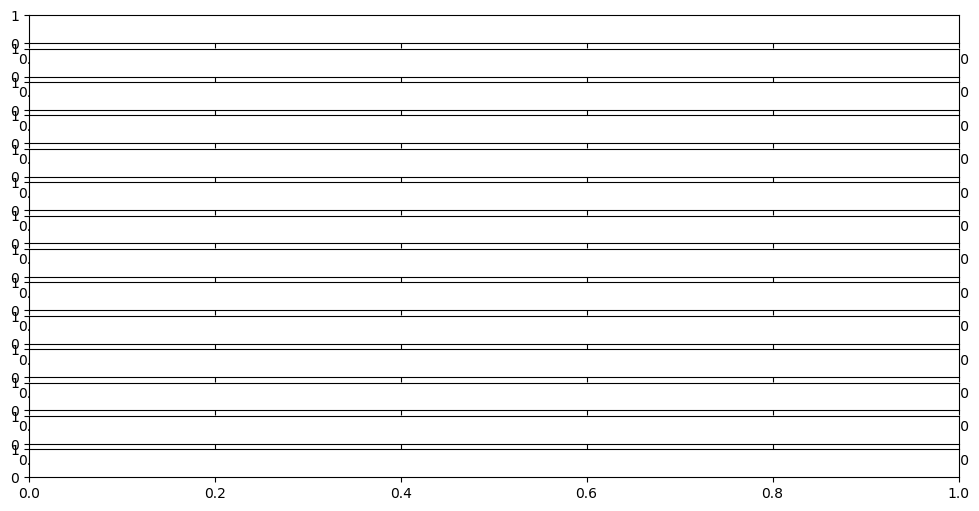

In [45]:
if iteration > 0: # VISUALIZATION OF TUNING PROGRESS
    try:
        with open (automation_dir + "simInput/tuning_log.json", "r") as f:
            tuning_log = json.load(f)

        param_df = pd.read_csv(automation_dir + "simInput/parameters.csv")
        attributes_df = pd.read_csv(automation_dir + "simOutput/AttributesLog.csv")

        param_df = param_df[param_df['Score'] >= 0] # filter out simulations that have not been scored yet

        ptypes = attributes_df['Sim'].values.tolist()
        ptypes = [x for x in ptypes if 'T' not in x] # remove tuning simulations for only real particles
        
        def str_to_float(str, tuning_log=tuning_log):
            if str != '':
                return float(str)
            else:
                return float(tuning_log['ZeroEnergy'])

        attr = attributes_df.columns.values.tolist()
        attr = [x for x in attr if x not in ['Sim', 'Energy']]

        fig, axes = plt.subplots(len(attr), len(ptypes), figsize=(12, 6))
        for i, particle in enumerate(ptypes):
            E0 = str_to_float(particle.split('a')[0].split('p')[0])
            E1 = str_to_float(particle.split('a')[0].split('p')[1])
            
            ptype_sims_params = param_df[param_df['E0'] == E0]
            ptype_sims_params = ptype_sims_params[ptype_sims_params['E1'] == E1]
            
            ptype_sims = ptype_sims_params['Sim'].values.tolist()
            
            ptype_attr = attributes_df[attributes_df['Sim'].isin(ptype_sims)]
            
            axes[0, i].set_title(particle)
            for j, atr in enumerate(attr):
                axes[j, 0].plot(ptype_attr.index, ptype_attr[atr], 'o')
                axes[j, 0].set_ylabel(atr)
                
                # horizontal line for tuning value
                axes[j,i].axhline(y=tuning_log['TargetAttributes'][particle][atr], color='k', linestyle='--')
                
        plt.savefig(automation_dir + "simOutput/Attributes.png")

        param_cols = param_df.columns.values.tolist()
        param_cols = [x for x in param_cols if x not in ['Sim', 'E0', 'E1', 'Status', 'P0', 'P1', 'N', 'Seed', 'Batch']]

        param_df['Batch'] = param_df['Sim'].apply(lambda x: float(x.split('T')[1].split('C')[0].split('G')[0]))
        center_params = param_df[param_df['Sim'].str.contains('C')]

        fig, axes = plt.subplots(len(param_cols), 1, figsize=(12, 6))
        for i, param in enumerate(param_cols):
            axes[i].plot(center_params['Batch'], center_params[param], color='r')
            axes[i].plot(param_df['Batch'], param_df[param], 'o', markersize=1, color='k')
            axes[i].set_ylabel(param)

        plt.savefig(automation_dir + "simOutput/Parameters.png")
    except:
        sys.exit(0)
sys.exit(0)

In [75]:
# Manual messing around section, won't run in automation loop
initialize_files()


Tuning Files Initialized


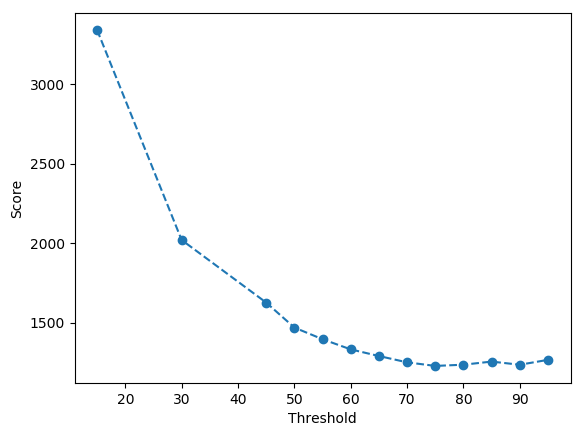

In [78]:
automation_dir = '/mnt/analysis/e17023/Adam/GADGET2/'
param_df = pd.read_csv(automation_dir + 'simInput/parameters.csv')

tuning_log = json.load(open(automation_dir + 'simInput/tuning_log.json'))
param_df = param_df[param_df['Status'] == 4]

param_df = Score_Simulations(param_df=param_df)

attribute_df = pd.read_csv(automation_dir + 'simOutput/AttributesLog.csv')
attribute_df = attribute_df[attribute_df['Sim'].isin(param_df['Sim'].values)]
# drop duplicates in attribute_df
attribute_df = attribute_df.drop_duplicates(subset='Sim', keep='last')
attribute_df['Threshold'] = param_df['Threshold'].values

plt.plot(param_df['Threshold'], param_df['Score'], 'o--')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.show();

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/user/jaros/.local/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


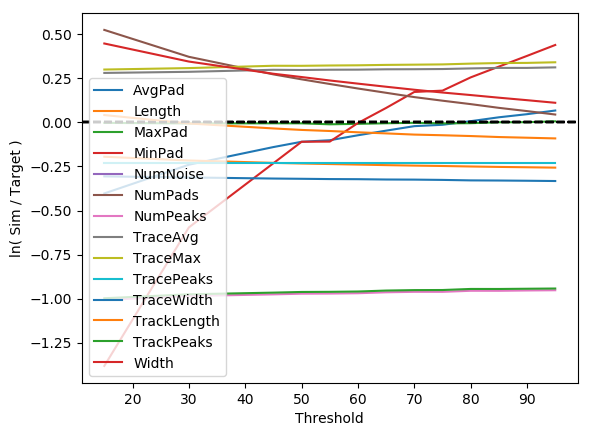

In [80]:
for attribute in attribute_df.columns.values.tolist():
    if attribute not in ['Sim', 'Energy', 'Threshold']:
        plt.plot(attribute_df['Threshold'], np.log(attribute_df[attribute] / tuning_log['TargetAttributes']['1682p'][attribute]), label=attribute)
        plt.axhline(y=0, color='k', linestyle='--')
        plt.xlabel('Threshold')
        plt.ylabel('ln( Sim / Target )')
        plt.legend()
        
        #plt.plot(attribute_df['Threshold'], attribute_df[attribute])
        #plt.xlabel('Threshold')
        #plt.ylabel(attribute)
        
        #plt.axhline(y=tuning_log['TargetAttributes']['1682p'][attribute], color='r', linestyle='--')
        #plt.show()